running for N =  40 with 2 processors


/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-1-d26d88b583d1>:84: RuntimeWarning: divide by zero encountered in log
  phasefunc = (1j * np.log(evals))/T
<ipython-input-1-d26d88b583d1>:84: RuntimeWarning: invalid value encountered in multiply
  phasefunc = (1j * np.log(evals))/T
<ipython-input-1-d26d88b583d1>:84: RuntimeWarning: invalid value encountered in true_divide
  phasefunc = (1j * np.log(evals))/T
<ipython-input-1-d26d88b583d1>:84: RuntimeWarning: divide by zero encountered in log
  phasefunc = (1j * np.log(evals))

time taken 3688.5415246486664 sec


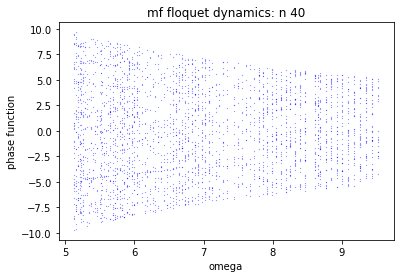

In [1]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time

start = time.time()

cosp_init = 0.0    
N = 40
h = 25.0
h0 = 0.1
    
q = np.linspace(-0.5, 0.5, N)
omega_range = np.linspace(10.5,19.5,90)
#bessel = [4*h/2.4048255576957, 4*h/5.52007811028631,\
#              4*h/8.65372791291101, 4*h/11.7915344390142, 4*h/14.9309177084877]
bessel = [4*h/5.52007811028631, 4*h/8.65372791291101]
omegas = np.hstack((omega_range,bessel))
psi = np.eye(N) + (1j) * np.zeros((N,N))

cosp = np.zeros((N,N)) + (1j) * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + (1j) * np.zeros((N,N))
floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))

title = "mf floquet dynamics: n " + str(N)
photoname = "n_" + str(N) + "_mfd.jpeg"
filename = "n_" + str(N) + "_mfd.txt"

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


def floq_jac(periodic_psi,t, h, h0, w, cosp):
    drive = h0 + h * np.cos(w * t)
    jac = (1j) * N * (-2.0 * q * q - drive * np.sqrt(1.0 - 4.0 * q *q) * cosp)
    return jac

def floq_func(periodic_psi,t,h,h0,w,cosp):
    return np.dot(floq_jac(periodic_psi,t, h0, h, w, cosp), periodic_psi)

def floq_evolv(periodic_psi,h,h0,w,cosp):
    T = 2 * np.pi/w     # time periode
    t = np.linspace(0,2 * np.pi/w,N)      # time range
    floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
    
    for mm in np.arange(N):
        psi0 = periodic_psi[mm]       
        psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp), Dfun=floq_jac)
        floqEvoluion_mat[mm] = psi_t[N-1]
    
    evals, evecs = eig(floqEvoluion_mat)
    phasefunc = (1j * np.log(evals))/T
    return phasefunc
    
if __name__ == '__main__':
    nprocs = 2
    p = Pool(processes = nprocs)  
    print("running for N = ", N, "with",nprocs,"processors")
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          math.comb(l,j)* periodic_psi[(k+(l-j),(m))]])
            cosp[k,m] = cospinit
            cospinit = 0.0
            
    data = p.starmap(floq_evolv,[(periodic_psi,h,h0,w,cosp) for w in omegas])
    
    print("time taken",time.time()-start,"sec")
    
    for xx, omg in enumerate(omegas):
        #omega = [omg] * N
        omega = [4*h/omg] * N
        plt.scatter(omega,data[xx].real, color='blue', marker='.', s= 0.1)
    plt.title(title)    
    plt.xlabel("omega")
    plt.ylabel("phase function")
    plt.savefig(photoname, dpi=350)
    plt.show()

In [2]:
h = 25.0
bessel = [4*h/2.4048255576957, 4*h/5.52007811028631,\
              4*h/8.65372791291101, 4*h/11.7915344390142, 4*h/14.9309177084877]
print(bessel)

[41.58305773156363, 18.115685684529797, 11.555713445855405, 8.480660470204269, 6.697511964931233]


running for N =  40 with 2 processors


/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


time taken 8739.30978679657 sec


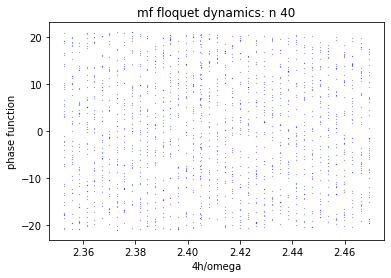

In [1]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time

start = time.time()

cosp_init = 0.0    
N = 40
h = 25.0
h0 = 0.1
    
q = np.linspace(-0.5, 0.5, N)
omega_range = np.linspace(40.5,42.5,40)
#bessel = [4*h/2.4048255576957, 4*h/5.52007811028631,\
#              4*h/8.65372791291101, 4*h/11.7915344390142, 4*h/14.9309177084877]
bessel = [4*h/2.4048255576957]
omegas = np.hstack((omega_range,bessel))
psi = np.eye(N) + (1j) * np.zeros((N,N))

cosp = np.zeros((N,N)) + (1j) * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + (1j) * np.zeros((N,N))
floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))

title = "mf floquet dynamics: n " + str(N)
photoname = "n_" + str(N) + "_mfd_bessel1.jpeg"
filename = "n_" + str(N) + "_mfd.txt"

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


def floq_jac(periodic_psi,t, h, h0, w, cosp):
    drive = h0 + h * np.cos(w * t)
    jac = (1j) * N * (-2.0 * q * q - drive * np.sqrt(1.0 - 4.0 * q *q) * cosp)
    return jac

def floq_func(periodic_psi,t,h,h0,w,cosp):
    return np.dot(floq_jac(periodic_psi,t, h0, h, w, cosp), periodic_psi)

def floq_evolv(periodic_psi,h,h0,w,cosp):
    T = 2 * np.pi/w     # time periode
    t = np.linspace(0,2 * np.pi/w,N)      # time range
    floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
    
    for mm in np.arange(N):
        psi0 = periodic_psi[mm]       
        psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp), Dfun=floq_jac)
        floqEvoluion_mat[mm] = psi_t[N-1]
    
    evals, evecs = eig(floqEvoluion_mat)
    phasefunc = (1j * np.log(evals))/T
    return phasefunc
    
if __name__ == '__main__':
    nprocs = 2
    p = Pool(processes = nprocs)  
    print("running for N = ", N, "with",nprocs,"processors")
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          math.comb(l,j)* periodic_psi[(k+(l-j),(m))]])
            cosp[k,m] = cospinit
            cospinit = 0.0
            
    data = p.starmap(floq_evolv,[(periodic_psi,h,h0,w,cosp) for w in omegas])
    
    print("time taken",time.time()-start,"sec")
    
    for xx, omg in enumerate(omegas):
        #omega = [omg] * N
        omega = [4*h/omg] * N
        plt.scatter(omega,data[xx].real, color='blue', marker='.', s= 0.1)
    plt.title(title)    
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")
    plt.savefig(photoname, dpi=400)
    plt.show()

running for N =  40 with 2 processors


/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-1-d0f6403f3ee5>:84: RuntimeWarning: divide by zero encountered in log
  phasefunc = (1j * np.log(evals))/T
<ipython-input-1-d0f6403f3ee5>:84: RuntimeWarning: invalid value encountered in multiply
  phasefunc = (1j * np.log(evals))/T
<ipython-input-1-d0f6403f3ee5>:84: RuntimeWarning: invalid value encountered in true_divide
  phasefunc = (1j * np.log(evals))/T
<ipython-input-1-d0f6403f3ee5>:84: RuntimeWarning: divide by zero encountered in log
  phasefunc = (1j * np.log(evals))

time taken 1831.0650618076324 sec


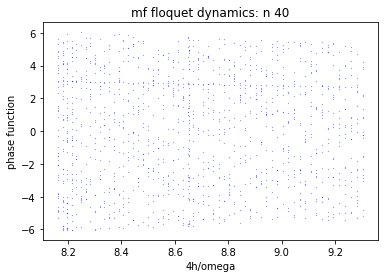

In [1]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time

start = time.time()

cosp_init = 0.0    
N = 40
h = 25.0
h0 = 0.1
    
q = np.linspace(-0.5, 0.5, N)
omega_range = np.linspace(10.75,12.25,60)
#bessel = [4*h/2.4048255576957, 4*h/5.52007811028631,\
#              4*h/8.65372791291101, 4*h/11.7915344390142, 4*h/14.9309177084877]
bessel = [4*h/8.65372791291101]
omegas = np.hstack((omega_range,bessel))
psi = np.eye(N) + (1j) * np.zeros((N,N))

cosp = np.zeros((N,N)) + (1j) * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + (1j) * np.zeros((N,N))
floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))

title = "mf floquet dynamics: n " + str(N)
photoname = "n_" + str(N) + "_mfd_bessel3.jpeg"
filename = "n_" + str(N) + "_mfd.txt"

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


def floq_jac(periodic_psi,t, h, h0, w, cosp):
    drive = h0 + h * np.cos(w * t)
    jac = (1j) * N * (-2.0 * q * q - drive * np.sqrt(1.0 - 4.0 * q *q) * cosp)
    return jac

def floq_func(periodic_psi,t,h,h0,w,cosp):
    return np.dot(floq_jac(periodic_psi,t, h0, h, w, cosp), periodic_psi)

def floq_evolv(periodic_psi,h,h0,w,cosp):
    T = 2 * np.pi/w     # time periode
    t = np.linspace(0,2 * np.pi/w,N)      # time range
    floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
    
    for mm in np.arange(N):
        psi0 = periodic_psi[mm]       
        psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp), Dfun=floq_jac)
        floqEvoluion_mat[mm] = psi_t[N-1]
    
    evals, evecs = eig(floqEvoluion_mat)
    phasefunc = (1j * np.log(evals))/T
    return phasefunc
    
if __name__ == '__main__':
    nprocs = 2
    p = Pool(processes = nprocs)  
    print("running for N = ", N, "with",nprocs,"processors")
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          math.comb(l,j)* periodic_psi[(k+(l-j),(m))]])
            cosp[k,m] = cospinit
            cospinit = 0.0
            
    data = p.starmap(floq_evolv,[(periodic_psi,h,h0,w,cosp) for w in omegas])
    
    print("time taken",time.time()-start,"sec")
    
    for xx, omg in enumerate(omegas):
        #omega = [omg] * N
        omega = [4*h/omg] * N
        plt.scatter(omega,data[xx].real, color='blue', marker='.', s= 0.1)
    plt.title(title)    
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")
    plt.savefig(photoname, dpi=400)
    plt.show()

running for N =  40 with 2 processors


/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-3-4fd27bbf07e7>:84: RuntimeWarning: divide by zero encountered in log
  phasefunc = (1j * np.log(evals))/T
<ipython-input-3-4fd27bbf07e7>:84: RuntimeWarning: invalid value encountered in multiply
  phasefunc = (1j * np.log(evals))/T
<ipython-input-3-4fd27bbf07e7>:84: RuntimeWarning: invalid value encountered in true_divide
  phasefunc = (1j * np.log(evals))/T
<ipython-input-3-4fd27bbf07e7>:84: RuntimeWarning: divide by zero encountered in log
  phasefunc = (1j * np.log(evals))

time taken 1503.7971024513245 sec


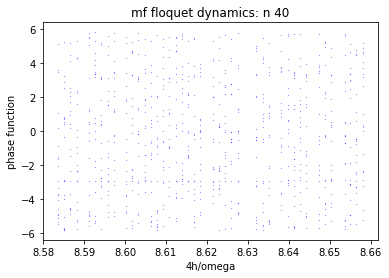

In [3]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time

start = time.time()

cosp_init = 0.0    
N = 40
h = 25.0
h0 = 0.1
    
q = np.linspace(-0.5, 0.5, N)
omega_range = np.linspace(11.55,11.65,50)
#bessel = [4*h/2.4048255576957, 4*h/5.52007811028631,\
#              4*h/8.65372791291101, 4*h/11.7915344390142, 4*h/14.9309177084877]
bessel = [4*h/8.65372791291101]
omegas = np.hstack((omega_range,bessel))
psi = np.eye(N) + (1j) * np.zeros((N,N))

cosp = np.zeros((N,N)) + (1j) * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + (1j) * np.zeros((N,N))
floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))

title = "mf floquet dynamics: n " + str(N)
photoname = "n_" + str(N) + "_mfd_bessel3a.jpeg"
filename = "n_" + str(N) + "_mfd.txt"

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


def floq_jac(periodic_psi,t, h, h0, w, cosp):
    drive = h0 + h * np.cos(w * t)
    jac = (1j) * N * (-2.0 * q * q - drive * np.sqrt(1.0 - 4.0 * q *q) * cosp)
    return jac

def floq_func(periodic_psi,t,h,h0,w,cosp):
    return np.dot(floq_jac(periodic_psi,t, h0, h, w, cosp), periodic_psi)

def floq_evolv(periodic_psi,h,h0,w,cosp):
    T = 2 * np.pi/w     # time periode
    t = np.linspace(0,2 * np.pi/w,N)      # time range
    floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
    
    for mm in np.arange(N):
        psi0 = periodic_psi[mm]       
        psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp), Dfun=floq_jac)
        floqEvoluion_mat[mm] = psi_t[N-1]
    
    evals, evecs = eig(floqEvoluion_mat)
    phasefunc = (1j * np.log(evals))/T
    return phasefunc
    
if __name__ == '__main__':
    nprocs = 2
    p = Pool(processes = nprocs)  
    print("running for N = ", N, "with",nprocs,"processors")
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          math.comb(l,j)* periodic_psi[(k+(l-j),(m))]])
            cosp[k,m] = cospinit
            cospinit = 0.0
            
    data = p.starmap(floq_evolv,[(periodic_psi,h,h0,w,cosp) for w in omegas])
    
    print("time taken",time.time()-start,"sec")
    
    for xx, omg in enumerate(omegas):
        #omega = [omg] * N
        omega = [4*h/omg] * N
        plt.scatter(omega,data[xx].real, color='blue', marker='.', s= 0.1)
    plt.title(title)    
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")
    plt.savefig(photoname, dpi=400)
    plt.show()

running for N =  40 with 2 processors


/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-9-f45d17c3b6e4>:85: RuntimeWarning: divide by zero encountered in log
  phasefunc = (1j * np.log(evals))/T
<ipython-input-9-f45d17c3b6e4>:85: RuntimeWarning: invalid value encountered in multiply
  phasefunc = (1j * np.log(evals))/T
<ipython-input-9-f45d17c3b6e4>:85: RuntimeWarning: invalid value encountered in true_divide
  phasefunc = (1j * np.log(evals))/T
<ipython-input-9-f45d17c3b6e4>:85: RuntimeWarning: divide by zero encountered in log
  phasefunc = (1j * np.log(evals))

time taken 449.29870676994324 sec


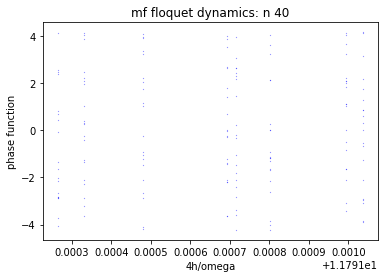

In [9]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time

start = time.time()

cosp_init = 0.0    
N = 40
h = 25.0
h0 = 0.1
    
q = np.linspace(-0.5, 0.5, N)
omega_range = np.linspace(8.4803,8.4809,40)
#bessel = [4*h/2.4048255576957, 4*h/5.52007811028631,\
#              4*h/8.65372791291101, 4*h/11.7915344390142, 4*h/14.9309177084877]
#bessel = [4*h/11.7915344390142]
#omegas = np.hstack((omega_range,bessel))
omegas = np.linspace(8.4803,8.4809,40)
psi = np.eye(N) + (1j) * np.zeros((N,N))

cosp = np.zeros((N,N)) + (1j) * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + (1j) * np.zeros((N,N))
floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))

title = "mf floquet dynamics: n " + str(N)
photoname = "n_" + str(N) + "_mfd_bessel4_check_delete_anytime.jpeg"
filename = "n_" + str(N) + "_mfd.txt"

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


def floq_jac(periodic_psi,t, h, h0, w, cosp):
    drive = h0 + h * np.cos(w * t)
    jac = (1j) * N * (-2.0 * q * q - drive * np.sqrt(1.0 - 4.0 * q *q) * cosp)
    return jac

def floq_func(periodic_psi,t,h,h0,w,cosp):
    return np.dot(floq_jac(periodic_psi,t, h0, h, w, cosp), periodic_psi)

def floq_evolv(periodic_psi,h,h0,w,cosp):
    T = 2 * np.pi/w     # time periode
    t = np.linspace(0,2 * np.pi/w,N)      # time range
    floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
    
    for mm in np.arange(N):
        psi0 = periodic_psi[mm]       
        psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp), Dfun=floq_jac)
        floqEvoluion_mat[mm] = psi_t[N-1]
    
    evals, evecs = eig(floqEvoluion_mat)
    phasefunc = (1j * np.log(evals))/T
    return phasefunc
    
if __name__ == '__main__':
    nprocs = 2
    p = Pool(processes = nprocs)  
    print("running for N = ", N, "with",nprocs,"processors")
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          math.comb(l,j)* periodic_psi[(k+(l-j),(m))]])
            cosp[k,m] = cospinit
            cospinit = 0.0
            
    data = p.starmap(floq_evolv,[(periodic_psi,h,h0,w,cosp) for w in omegas])
    
    print("time taken",time.time()-start,"sec")
    
    for xx, omg in enumerate(omegas):
        #omega = [omg] * N
        omega = [4*h/omg] * N
        plt.scatter(omega,data[xx].real, color='blue', marker='.', s= 0.1)
    plt.title(title)    
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")
    plt.savefig(photoname, dpi=500)
    plt.show()

running for N =  40 with 2 processors


/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-2-2200a58da02d>:85: RuntimeWarning: divide by zero encountered in log
  phasefunc = (1j * np.log(evals))/T
<ipython-input-2-2200a58da02d>:85: RuntimeWarning: invalid value encountered in multiply
  phasefunc = (1j * np.log(evals))/T
<ipython-input-2-2200a58da02d>:85: RuntimeWarning: invalid value encountered in true_divide
  phasefunc = (1j * np.log(evals))/T
<ipython-input-2-2200a58da02d>:85: RuntimeWarning: divide by zero encountered in log
  phasefunc = (1j * np.log(evals))

time taken 6499.9444036483765 sec


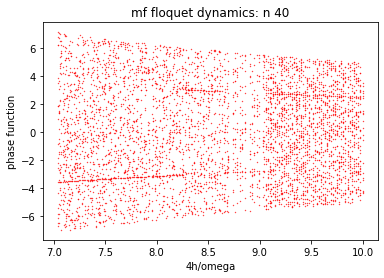

In [2]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time

start = time.time()

cosp_init = 0.0    
N = 40
h = 25.0
h0 = 0.1
    
q = np.linspace(-0.5, 0.5, N)
#omega_range = np.linspace(10.0,14.2,200)
#bessel = [4*h/2.4048255576957, 4*h/5.52007811028631,\
#              4*h/8.65372791291101, 4*h/11.7915344390142, 4*h/14.9309177084877]
#bessel = [4*h/5.52007811028631, 4*h/8.65372791291101]
#omegas = np.hstack((omega_range,bessel))
omegas = np.linspace(10.0,14.2,200)
psi = np.eye(N) + (1j) * np.zeros((N,N))

cosp = np.zeros((N,N)) + (1j) * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + (1j) * np.zeros((N,N))
floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))

title = "mf floquet dynamics: n " + str(N)
photoname = "n_" + str(N) + "_mfd_bessel3b.jpeg"
filename = "n_" + str(N) + "_mfd.txt"

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


def floq_jac(periodic_psi,t, h, h0, w, cosp):
    drive = h0 + h * np.cos(w * t)
    jac = (1j) * N * (-2.0 * q * q - drive * np.sqrt(1.0 - 4.0 * q *q) * cosp)
    return jac

def floq_func(periodic_psi,t,h,h0,w,cosp):
    return np.dot(floq_jac(periodic_psi,t, h0, h, w, cosp), periodic_psi)

def floq_evolv(periodic_psi,h,h0,w,cosp):
    T = 2 * np.pi/w     # time periode
    t = np.linspace(0,2 * np.pi/w,N)      # time range
    floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
    
    for mm in np.arange(N):
        psi0 = periodic_psi[mm]       
        psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp), Dfun=floq_jac)
        floqEvoluion_mat[mm] = psi_t[N-1]
    
    evals, evecs = eig(floqEvoluion_mat)
    phasefunc = (1j * np.log(evals))/T
    return phasefunc
    
if __name__ == '__main__':
    nprocs = 2
    p = Pool(processes = nprocs)  
    print("running for N = ", N, "with",nprocs,"processors")
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          math.comb(l,j)* periodic_psi[(k+(l-j),(m))]])
            cosp[k,m] = cospinit
            cospinit = 0.0
            
    data = p.starmap(floq_evolv,[(periodic_psi,h,h0,w,cosp) for w in omegas])
    
    print("time taken",time.time()-start,"sec")
    
    for xx, omg in enumerate(omegas):
        #omega = [omg] * N
        omega = [4*h/omg] * N
        plt.scatter(omega,data[xx].real, color='red', marker='.', s= 0.5)
    plt.title(title)    
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")
    plt.savefig(photoname, dpi=500)
    plt.show()